## Introduction

A constant density parameter might not be able to characterize the underlying structure of a real-world dataset with noise and varying cluster density. Here, we have a 2D synthetic dataset with varying cluster density is presented below. It consists of four clusters ($C_1, \cdots, C_4$).
 <center>
 <figure>


<p>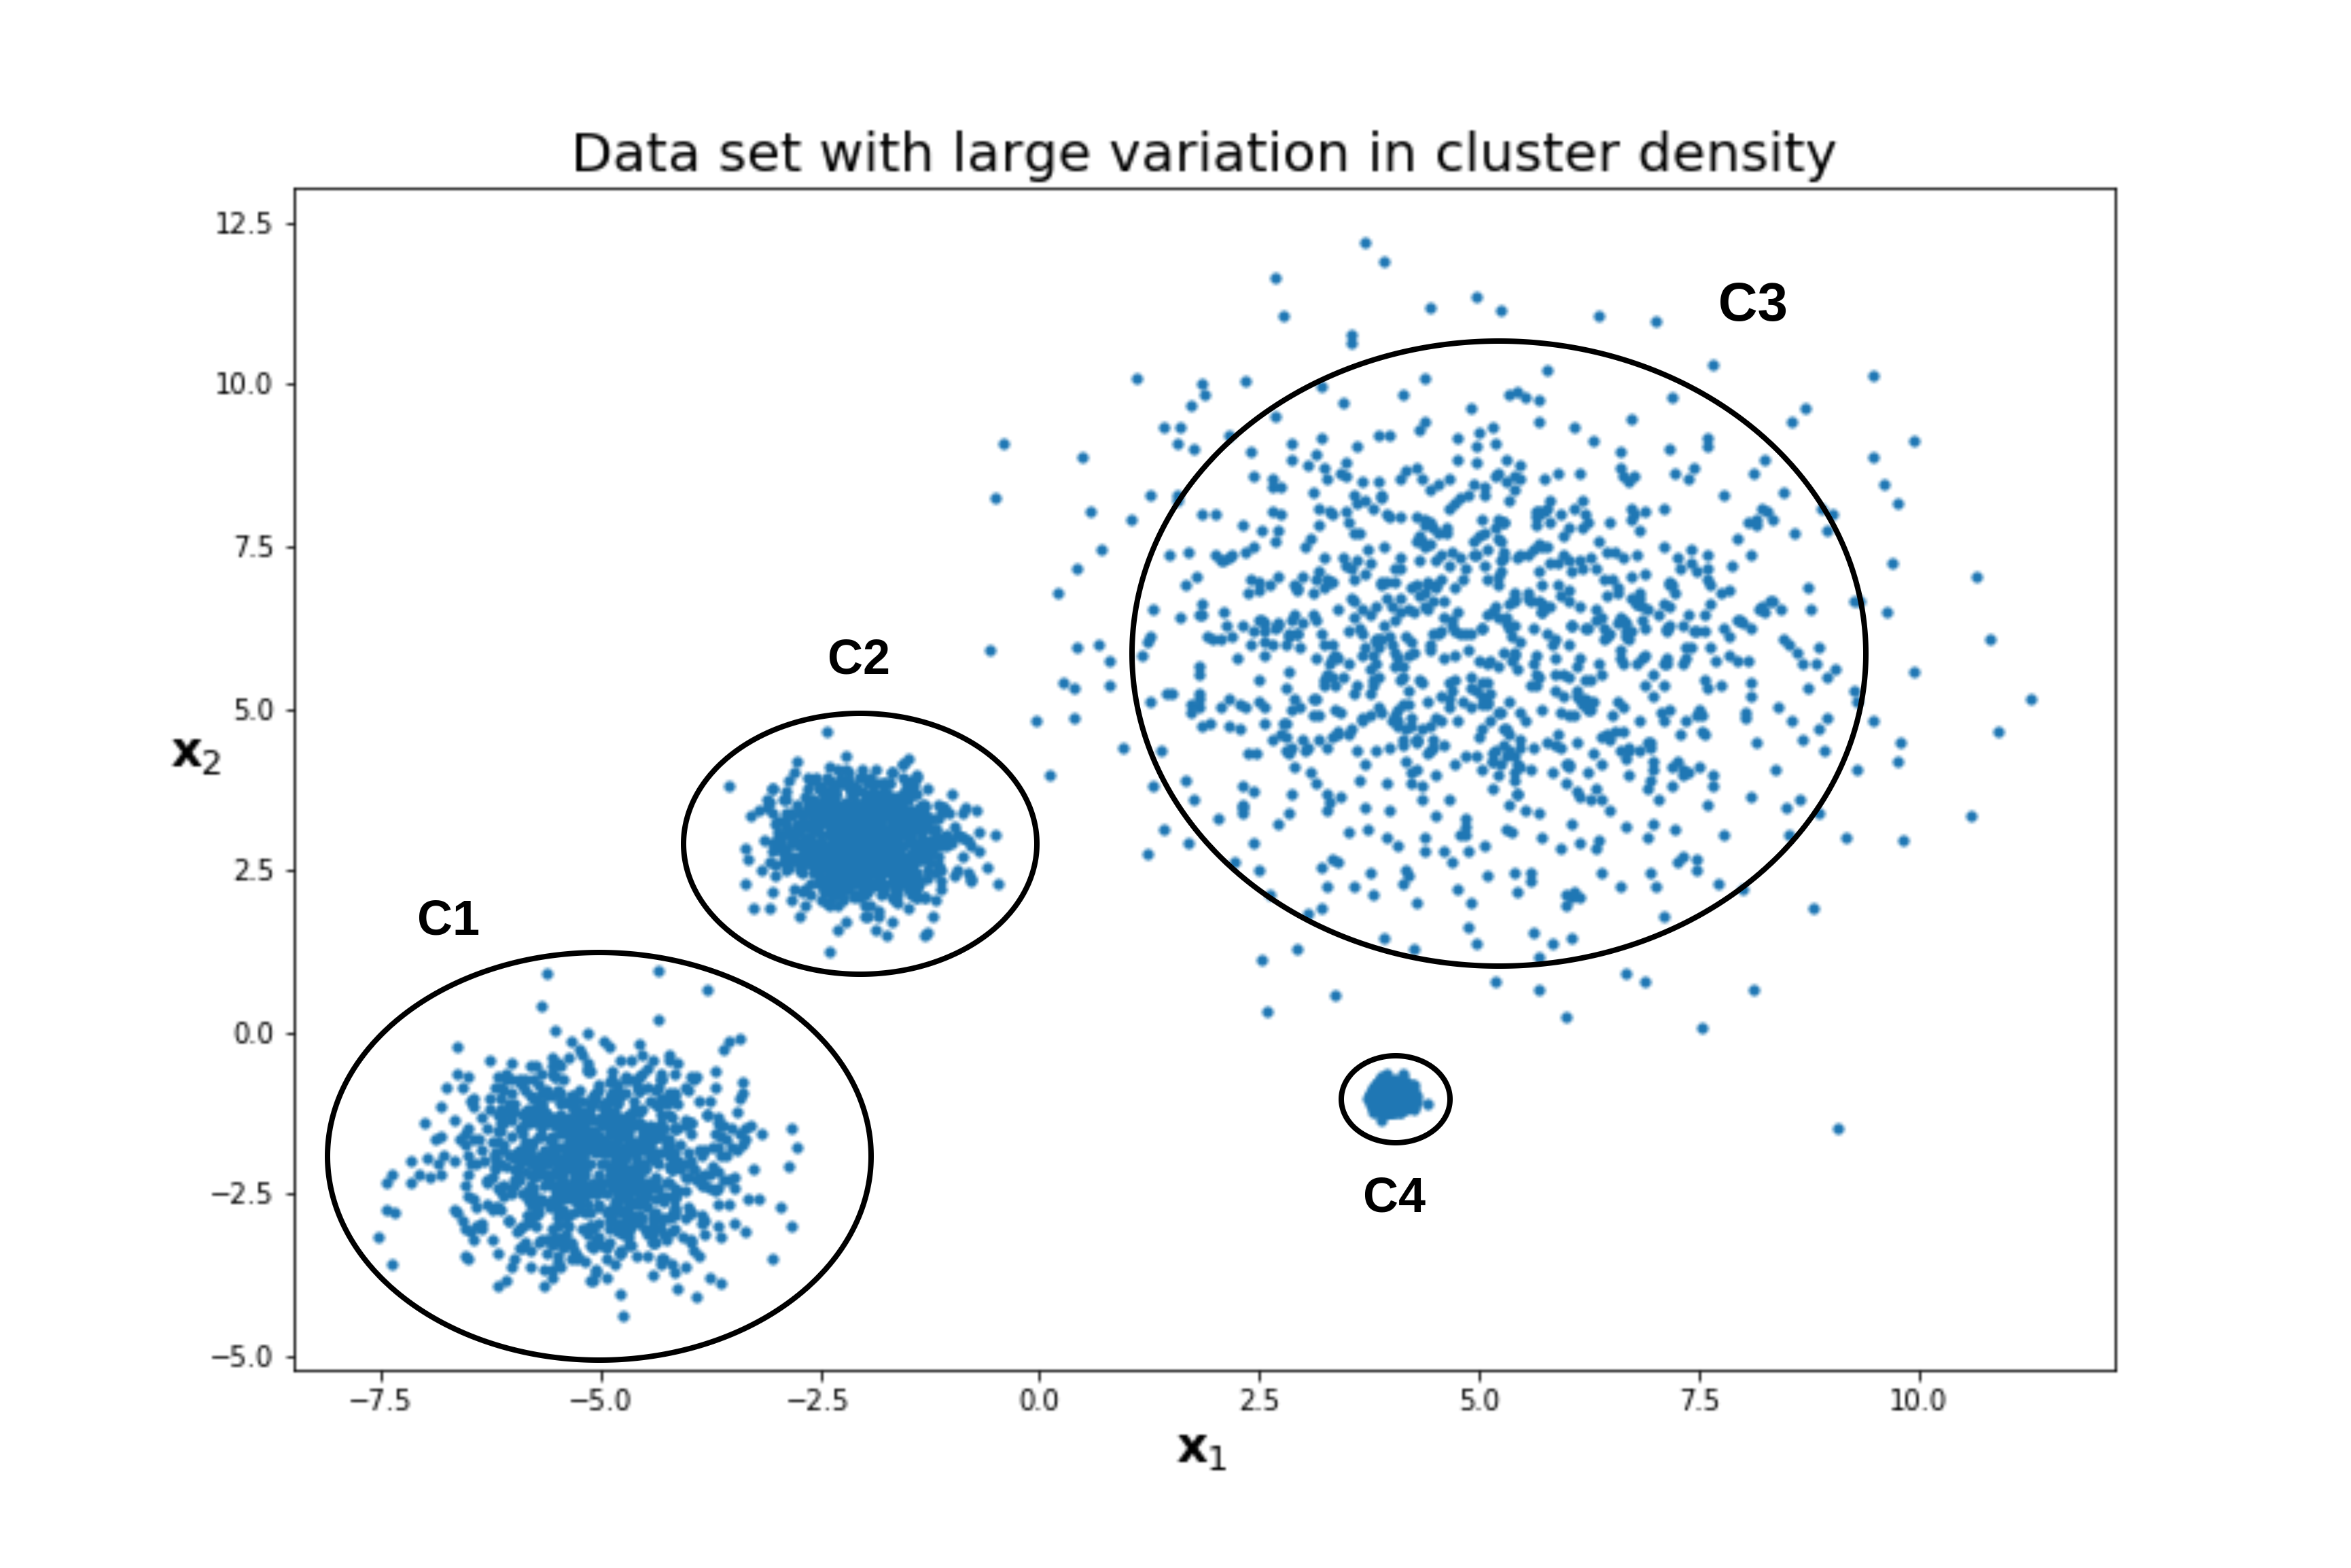</p>
    <figcaption>Figure 1: 2D Dataset consisting of cluster with varying density.</figcaption>
 </figure>
 </center>

Varying local densities are present within each cluster. As DBSCAN assumes a constant density of the neighborhood, it's unable to cluster data point having a significant variation in density. 

 <center>
 <figure>


<p>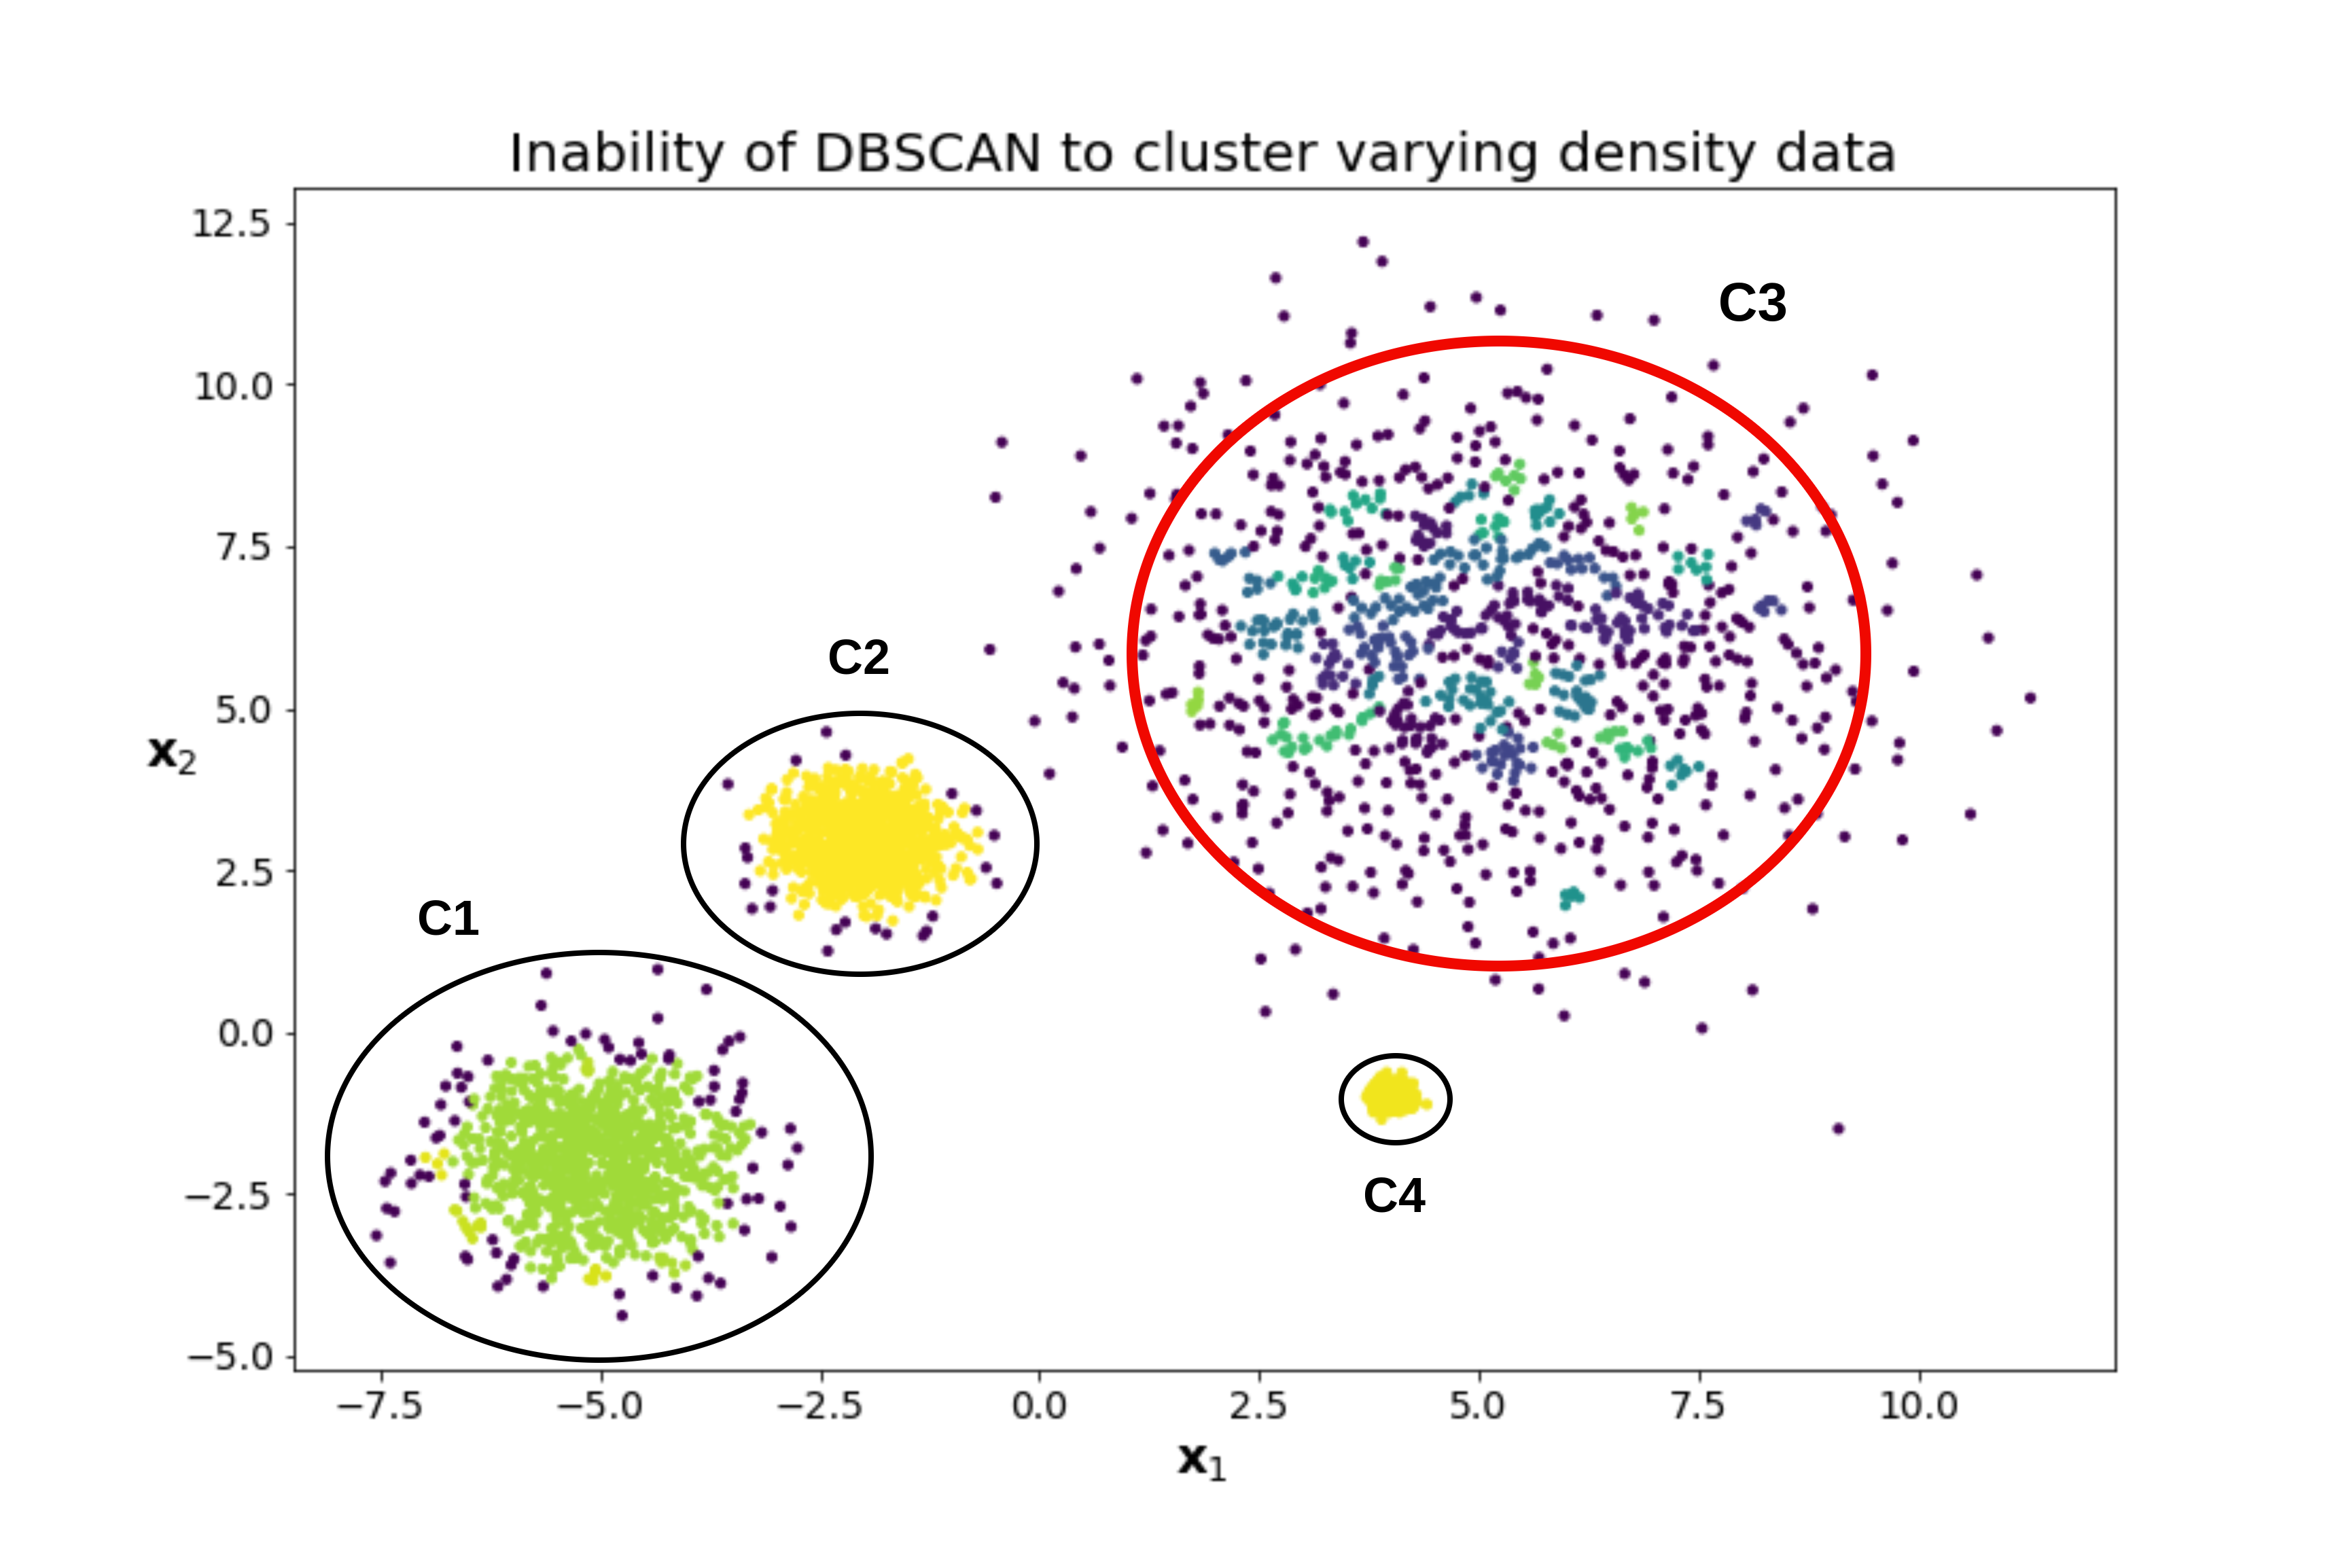</p>
    <figcaption>Figure 2: Inability of DBSCAN to cluster varying density clusters.</figcaption>
 </figure>
 </center>
 
Figure 2 shows the clustering result of DBSCAN using scikit-learn with default parameters. DBSCAN identified clusters C1, C2, and C4, but failed to cluster sparse cluster C3. Assuming constant density resulted in the formation of multiple smaller clusters within C3.

To overcome this problem, in 1999, Mihael Ankerst, Markus M. Breunig, Hans-Peter Kriegel, Jörg Sander introduced [OPTICS]( https://www.dbs.ifi.lmu.de/Publikationen/Papers/OPTICS.pdf) (Ordering Points To Identify the Clustering Structure), an extension of DBSCAN, able to __find clusters in data with varying density__. **Note**: OPTICS doesn't perform clustering explicitly, but instead creates an ordering of the data points that comprehends the density-based clustering structure, such that spatially close points are near  in the ordering. Later the order is analyzed for forming clusters.

As there is no explicit clustering involved in OPTICS, the authors propose two techniques for clustering the dataset after ordering, interactive, and automatic analysis techniques. We will be looking at the interactive analysis technique in this notebook.


## Density-based cluster-ordering

OPTICS is an extension of DBSCAN, i.e., OPTICS uses all the parameters/terminologies used in DBSCAN. However, OPTICS requires knowledge of two additional terms required for ordering the cluster density. Before that, let's gain the notion of density-based cluster-ordering.

As stated, OPTICS performs ordering of clusters based on value of density. For a constant $\text{MinPts}$, higher density clusters (low $\epsilon$) are completely contained in lower density cluster (high $\epsilon$), illustrated in figure below.
 <center>
 <figure>


<p>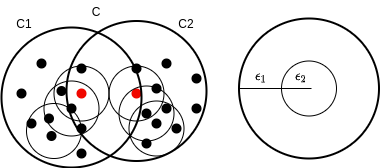</p>
     <figcaption>Figure 3: Visualization of Nested nature of clusters, Source: Ankerst M. et al. 1999</figcaption>
  </figure>
  </center>
  
  As seen in figure 3, dense clusters and within sparse clusters. Within $\text{MinPts} = 3$, and $\epsilon_2 < \epsilon_1$, C1 and C2 are denser clusters with respect to $\epsilon_2$ and C which comprehends of C1 and C2 is clusters based on $\epsilon_1$.
  
Using this knowledge, in principle, OPTICS extends DBSCAN by processing infinite varying density-based clusters with several radii ($\epsilon_i$) that are smaller than $\epsilon$, given as input parameter, i.e. $0 \leq \epsilon_i \leq \epsilon$ simultaneously. The difference between OPTICS and DBSCAN is OPTICS stores the order of processing the data points according to its notion of density without explicit cluster assignment. 

To produce consistent result, OPTICS selects a random core point and order points that are density-reachable with respect to values of $\epsilon$. Points within reach of smaller $\epsilon$ are ordered first. Doing so results in data points in clusters being listed close to each other. To contain the information regarding the order, we have to learn two new terms computed for every data point, which are:

- __Core-distance__

  For a data point $p \in D$, the core-distance is the smallest distance $\epsilon'$ to classify $p$ as a core point, given constant $\text{MinPts}$ (Ankerest, 1999). If $p$ isn't a core-point, its core-distance is undefined. In other words, core-distance for $p$ is the distance from $p$ to its $\text{MinPts}^\text{th}$ neighbour. Mathematically,
  
  $$
  \text{core-distance}_{\epsilon, \text{MinPts}}(p) = \begin{cases}
  \text{undefined}, & \text{if}  \ |N_\epsilon(p)| < \text{MinPts} \\
  \text{MinPts-distance(p)}, & \text{otherwise}
  \end{cases} 
  $$
     
  where, $\text{MinPts-distance(p)}$ is the distance from $p$ to its $\text{MinPts}^\text{th}$ nearest neighbor.
  
  <center>
  <figure>


<p>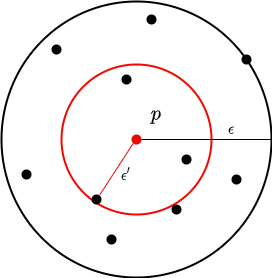</p>
     <figcaption>Figure 3: Visualizing core distance of point P</figcaption>
  </figure>
  </center>

  Figure 3 visualizes the core distance for a core-point $p$ with $\epsilon=3, \text{MinPts}=4$. Since, $p$'s neighborhood contains 4 neighbors within $\epsilon'$ distance, it is the core-distance for $p$, represented by red line.
  
- __Reachability-distance__

  For a data point $q \in D$ and core-point $p \in D$, the reachability distance between a $p$ and $q$ is the distance between $p$ and $q$, such that $q$ is directly density reachable from $p$ (Ankerest, 1999). Note: the reachability-distance cannot be less than core-distance, because for smaller distance than data point isn't directly density reachable from $p$. Mathematically,
  
  $$
  \text{reachability-distance}_{\epsilon, \text{MinPts}}(q,p) = \begin{cases}
  \text{undefined}, & \text{if}  \ |N_\epsilon(p)| < \text{MinPts} \\
  \max(\text{core-distance}(p), \text{dist}(p,q)), & \text{otherwise}
  \end{cases} 
  $$
  
  
  <center>
  <figure>


<p>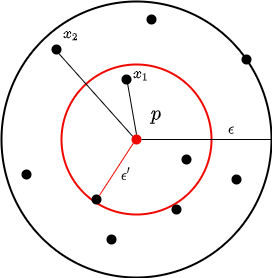</p>
     <figcaption>Figure 4: Visualizing reachability distance</figcaption>
  </figure>
  </center>
  
  Figure 4 visualizes the reachability distance for $x_1, x_2$ with respect to $p$. The reachability-distance is given as:
  
  $$
  \text{reachability-distance}_{\epsilon, \text{MinPts}}(x_1,p) =\max(\text{core-distance}(p), \text{dist}(p,x_1)) = \text{core-distance}(p) \\
  \text{reachability-distance}_{\epsilon, \text{MinPts}}(x_2,p) =\max(\text{core-distance}(p), \text{dist}(p,x_2)) = \text{dist}(p,x_2)
  $$

Finally, we are ready to discuss the algorithm of OPTICS.


## Algorithm

We will be discussing the abstract algorithm and pseudo-code for OPTICS. This algorithm also requires finding the neighbors. However, OPTICS uses ```find_neighbors``` function instead of ```range_query```. Unlike ```range_query``` that finds the _directly density reachable_ points, ```find_neighbors``` gets all the _density reachable_ points from a core point.

The key point to remember is OPTICS _orders the data points with respect to the reachability distance_. The storage of order of computation is done using priority queue (or heap memory) based on reachability distance. A priority queue is a data structure, with each element having a "priority" associated with it.  

In short, the above OPTICS works as follows:

All data points are unprocessed with undefined reachability distance at the start. 

1. Select a random unprocessed data point, set the point as processed, append it to the ordered list.

2. Calculate the core-distance and If the point is a core point, call update function that:
  1. Compute its neighbors w.r.to $\epsilon$ and $\text{MinPts}$,.
  2. Compute the reachability distance of those neighbors and update the priority of processing the neighbors. Note: ```Seed```, a priority queue stores tuple-(data point, reachability distance from nearest core point) with smaller reachability distance getting higher priority. 
  
  Repeat step 1-2(except selection of data points) for the neighbors of each neighbor of the original core point, until all are processed.

3. Go to step 1, until all data points are processed
4. Return the ordered list of locations according to reachability distance.




---
### Pseudo-code

---

Following is the pseudo-code for implementing the OPTICS algorithm. ```OPTICS``` function returns the ordered list is the list containing density-based cluster's order w.r.to the reachability distance. 


```
OPTICS(DB, dist_func, eps, min_pts):

    for each point P of DB:
        P.reachability_dist = UNDEFINED                        # Initializing the reachability distance
                                                      
    for each unprocessed point P of DB: 
        Neighbors N = find_neighbors(DB, dist_func, P, eps)    # Querying neighbours of the selected point

        mark P as processed
        output P to the ordered list

        if (core_dist(P, eps, min_pts) != UNDEFINED):          # Checking if a data point is outlier
          Seeds = empty priority queue                         # Initializing a priority queue 

          update(N, P, Seeds, eps, min_pts)                    # Calling the update function
 
          for each next Q in Seeds:                            # Repeating the process for the neighbors
             Neighbors N' = find_neighbors(DB, dist_func, q, eps)

             mark Q as processed
             output Q to the ordered list

             if (core_dist(Q, eps, min_pts) != UNDEFINED):
                update(N', Q, Seeds, eps, min_pts, dist_func)
                
    return ordered list
                
```    

---
#### Pseudo-code for update

---

```update``` function calculates the reachability distance of neighbors from a given core point and assigns a higher priority of computation for smaller reachability distance. Note: reachability distance from nearest core point is kept. In such a way, the output ordered list contains data points in a cluster near to each other.

```
update(N, P, Seeds, eps, min_pts, dist_func):

    core_distance = core_dist(P, eps, min_pts)                 # Calculating core distance for given point
    
    for each Q in N:                                           # Updating the Reachability distance for each 
                                                               # neighbour of P
       if (Q is not processed):
          new_reachability_dist = max(core_distance, dist_func(P, Q))

          if (Q.reachability_dist == UNDEFINED):               # Checking if the neighbour point is in seeds
              Q.reachability_dist = new_reachability_dist      # Update step
              Seeds.insert(Q, new_reachability_dist)           # Insertion to priority queue
          else:               
              if (new_reachability_dist < Q.reachability_dist):# Store shortest reachability distance.
                 Q.reachability_dist = new_reachability_dist
                 Seeds.move-up(Q, new_reachability_dist)       # Moves smaller distance to higher priority
```

The original paper generated cluster-ordering consisting of the ordering of points, reachability-distance, and core-distance. However, the above pseudo-code implementation uses only the ordering of points and reachability-distance, which provides enough information for clustering.




### Runtime complexity

Since the ```find_neighbors``` function is similar to ```range_query``` used in DBSCAN, and the function runs at least once for every point in the dataset, the runtime complexity is from $O(n\log n)$ to $O(n^2)$ depending on use of spatial access method and type of data. In the original paper, the authors report OPTICS being 1.6 times slower than the DBSCAN algorithm.


## Reachability Plot for clustering

After ordering of clusters, one way to understand the structure of cluster-ordering is using a graphical representation. The authors provide an interactive analysis technique that uses the reachability plot for clustering the data points. __Reachability plots__ for a 2-dimensional dataset is a graph representing the ordering of data points in the x-axis and respective reachability distance in the y-axis. Note: The reachability plot and its visualization are quite insensitive to the parameters $\epsilon$, $\text{MinPts}$(should be larger than "some" value found through hit and trail).

<center>
    <figure>


<p>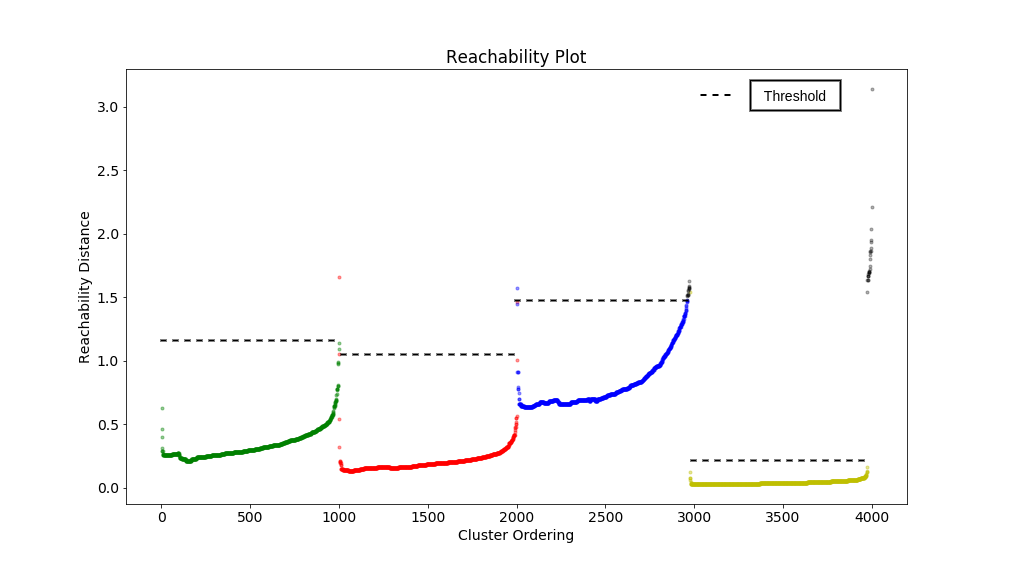</p>
    <figcaption>Figure 6: Reachability plot for 2D dataset</figcaption>
    </figure>
</center>

The figure above shows the reachability plot for the previously generated synthetic dataset. As the data points in a cluster have similar reachability distance to its nearest core point, the clusters appear as *valleys*(slight change in distance) in the reachability plot. Deeper valleys(lower reachability distance) represent denser clusters. The *peaks* in the reachability plots separate the clusters and represent the distance required to travel between clusters or from cluster to noise to cluster.

As said before, OPTICS doesn't explicitly cluster the points; it only handles the ordering of density-based ordering. The separation of clusters(assignment of colors to a data point in figure 6) from reachability plot is done, either by manually selecting threshold(dotted line in figure 6) on the y-axis for a range of x-axis values or by using an automatic algorithm that uses $\xi$ parameter to compute steep points and areas to detect start and end of valleys and cluster the data points accordingly. Discussion of the __automatic technique__  is beyond the scope of this course, but if you are interested, do refer to section 4.3.1 of the paper linked in the 1st subsection.

Let's plot the clusters obtained using density-based cluster-ordering and setting threshold values.

<center>
    <figure>


<p>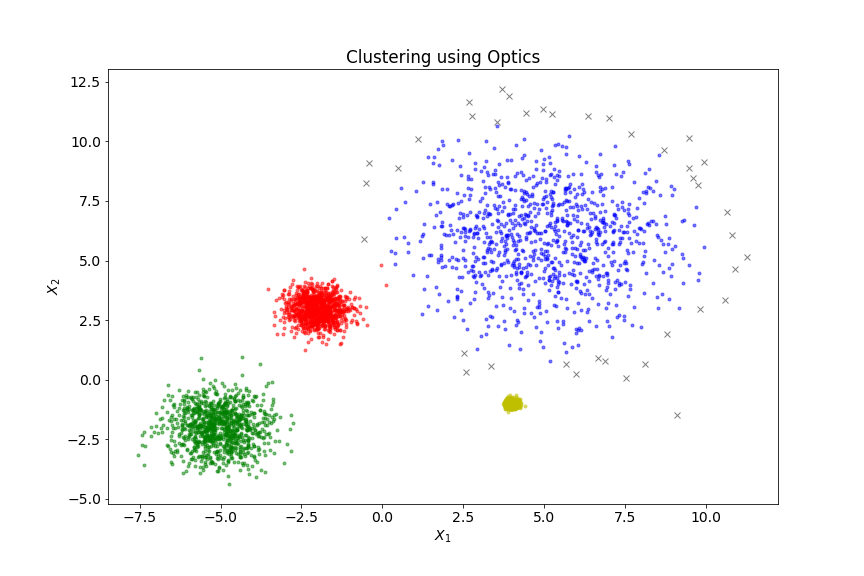</p>
    <figcaption>Figure 7: Clustering of synthetic dataset using OPTICS</figcaption>
    </figure>
</center>

Look how beautifully OPTICS algorithm clusters the varying density data in comparison to DBSCAN. Any points between the threshold region are labeled as noise. Comparing the cluster color with the reachability distance, the densest cluster represented by yellow color has the deepest valley, while the least dense cluster, represented by blue, has the shallowest valley. Though DBSCAN doesn't perform clustering using reachability plots, a conceptual comparison of the threshold for DBSCAN is presented in the figure below.

<center>
    <figure>


<p>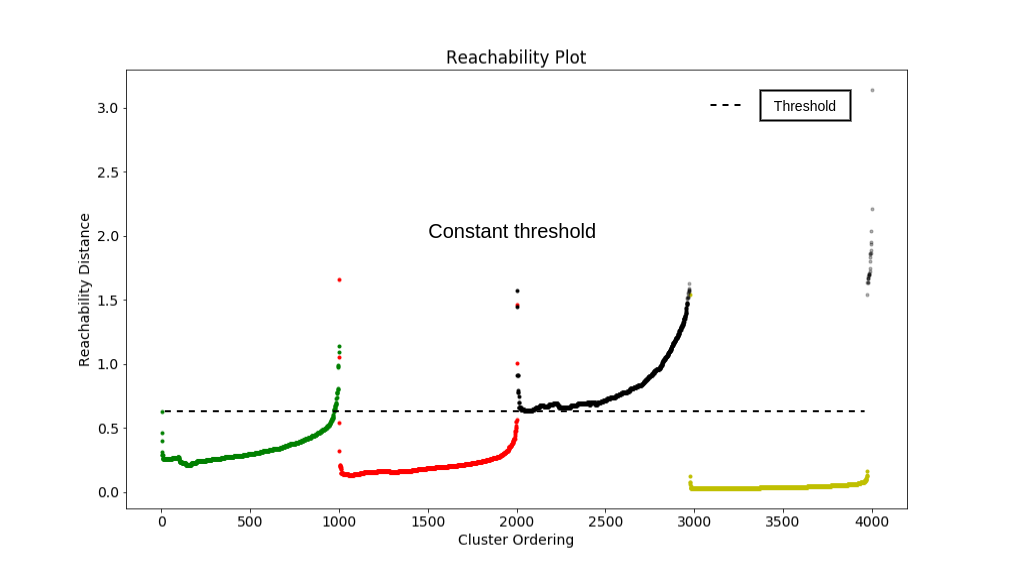</p>
    <figcaption>Figure 8: Threshold for DBSCAN in reachability plot</figcaption>
    </figure>
</center>

DBSCAN assumes constant density for all clusters, i.e., the threshold for separation of clusters is constant. For example, if the threshold is set for 0.5, blue, red and yellow clusters are detected, but the previous blue cluster is labeled as noise. This concludes the clustering of data points using the OPTICS algorithm. Finally, let's move on to the discussion of the advantage and limitations of the OPTICS algorithm.


## Pros/Cons

Similar to DBSCAN, OPTICS also have its pros ans cons:


### Pros

1. Like DBSCAN, OPTICS doesn't require specification of the number of clusters and can detect outliers and cluster non-convex datasets.
2. Detect clusters of varying density.
3. More insensitive in terms of parameters $\epsilon$ and $\text{MinPts}$ than DBSCAN, so it is known as a seemingly parameterless algorithm.

  - $\epsilon$ influences the number/shape of clustering-levels. A smaller value of $\epsilon$ results in the reachability distance of more data-points being undefined. As a result, we might not see clusters with lower density. (Ankerst, 1999)
  
  - $\text{MinPts}$ only influences the smoothness of the reachability plot. Smaller value makes the reachability plot more jagged while larger values smoothen the plot. (Ankerst, 1999)

    <center>
    <figure>


<p>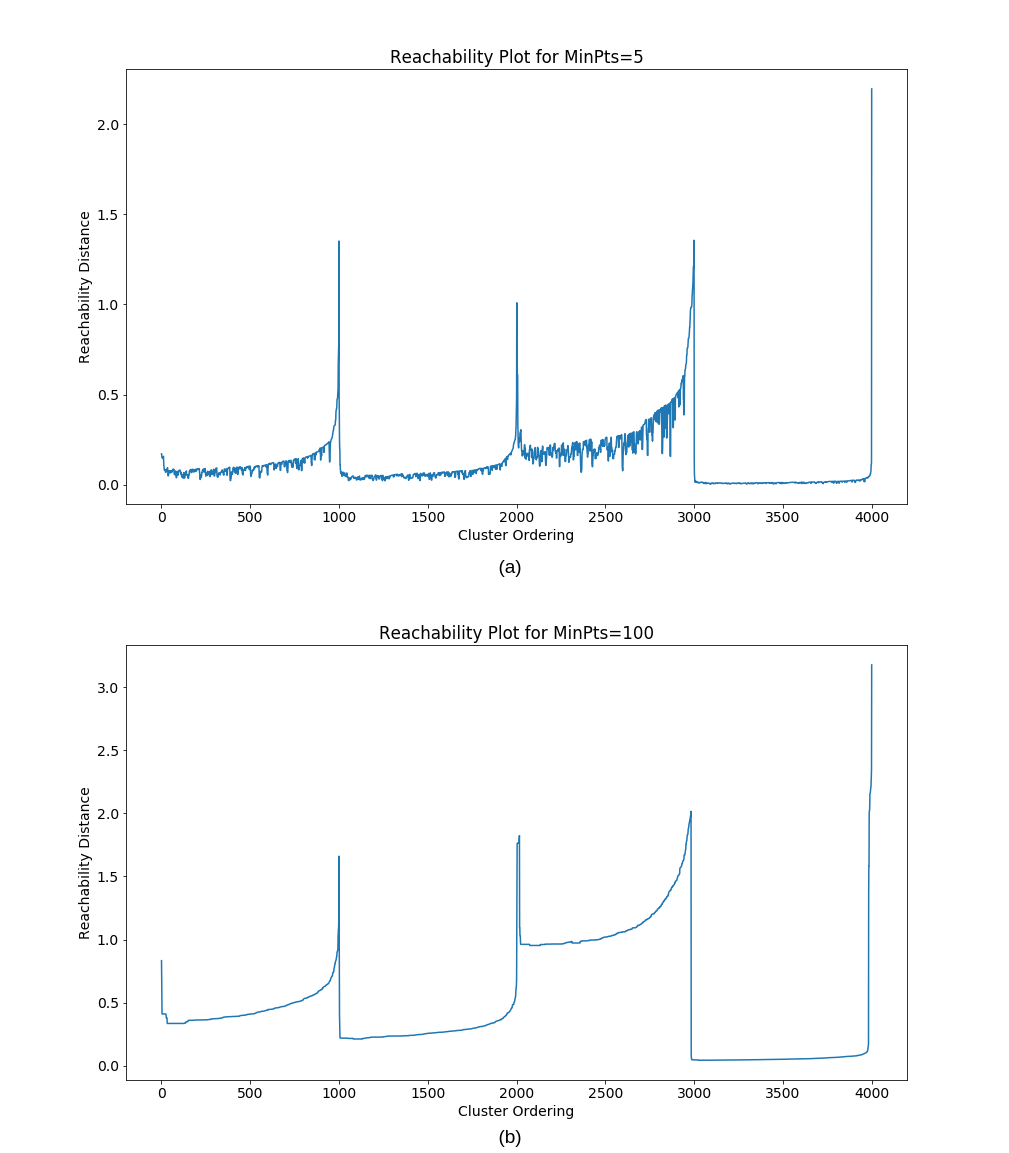</p>
    <figcaption>Figure 9: Reachability plot for different value of MinPts (a) MinPts=5 | (b) MinPts=100</figcaption>
    </figure>
    </center>

    As you can see $\text{MinPts}$ parameter only changes the smoothness of the reachability plot. Lower value outputs a more jagged plot, but the valley and peaks of the reachability plot are preserved.


### Cons

1. Require more memory than DBSCAN. It uses priority queues/min heaps to order the data points according to the reachability distance.
2. Slower than DBSCAN, approximately 1.6 times slower.
3. Unavailability of explicit cluster assignment, though some automatic assignment methods are present.

Thats all for reading regarding OPTICS. In the next chapter, we are learning the implementation of DBSCAN.


## Key-Takeaways

1. OPTICS is an extension of DBSCAN, which detects the different density clusters using density-based cluster-ordering. However, OPTICS doesn't explicitly assign clusters to datapoints and is approximately 1.6 times slower than DBSCAN.

2. OPTICS consists of an additional two terms known as core-distance and reachability-distance for gaining notion of density-based cluster-ordering:
    - core-distance : the smallest distance $\epsilon'$ to classify data point as a core point, given constant $\text{MinPts}$.
    - reachability-distance: for data point $p$ and $q$, it's the distance between $p$ and $q$, such that $q$ is directly density reachable from $p$. It must be equal to or greater than core-distance.
    
    
3. OPTICS orders the data points concerning the reachability distance from core points. 

4. For explicit cluster assignment requires help of a reachability plot where the x-axis represent ordering of data points, and the y-axis represent reachability distance. The valleys represent clusters(where deeper valley represent denser cluster) and peak represent the separation of clusters.

5. Using a reachability plot explicit cluster assignment is either done manually using the programmer's inspection or by using an automatic - $\xi$ method.

6. Reachability plots are rather insensitive to input parameters $\epsilon$ and $\text{MinPts}$. So in OPTICS, the parameters must be selected above some value, obtained using hit and trial.
